Purpose of this notebook:

1. Enable quick manual segmentation of large TIF images containing multiple tiles in x-y and multiple z-planes, in a single channel
2. Create a table of cells X ROIs also containing information about the location of the cell in vivo (within a particular FOV)
3. Allow each cell to have ROIs in multiple z planes
4. Work with single image stitched in x-y if possible
5. Use ROIs from one channel to calculate intensity in other channels and produce histogram

# Setup

In [3]:
!conda install ipykernel --name py365

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.4.6
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base conda




In [4]:
!python -m ipykernel install

Installed kernelspec python3 in C:\ProgramData\jupyter\kernels\python3


In [1]:
%gui qt5 

In [2]:
# Imports in alphabetical order of module name

from PIL import Image, ImageDraw
import napari
import numpy as np
import pickle as pkl
import matplotlib.path as mpltpath
import matplotlib.pyplot as plt


# Load images

In [3]:
## Specify images to load

folder = 'Y:\Svoboda Lab\Amrita\HCR_9.2\S4_dapi_546_488_647-02'
base_filename = 'S4_dapi_546_488_647-02_s1z'
plane_nos = range(15, 29)
n = len(plane_nos)
print('Number of planes: {0}'.format(n))

Number of planes: 14


In [4]:
# Create 4D array to store images
img = Image.open('{0}\{1}{2}c1+2+3+4.tif'.format(folder, base_filename, str(plane_nos[0])))
h = img.height
w = img.width
c = np.array(img).shape[2]
im_array = np.zeros([n, h, w, c])
print('Size of image in pixels: {0} X {1} X {2}'.format(n, h, w))

for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    img = Image.open('{0}\{1}{2}c1+2+3+4.tif'.format(folder, base_filename, str(p)))
    try:
        im_array[i, :, :, :] = np.array(img)
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array = np.delete(im_array, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue


FileNotFoundError: [Errno 2] No such file or directory: 'Y:\\Svoboda Lab\\Amrita\\HCR_9.2\\S4_dapi_546_488_647-02\\S4_dapi_546_488_647-02_s1z15c1+2+3+4.tif'

In [20]:
im_array_egln3 = np.zeros([n, h, w])
for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    img = Image.open('{0}\{1}{2}_AF488-T2_ORG.tif'.format(folder, base_filename,str(p).zfill(2)))
    try:
        full_im = np.array(img)
        im_array_egln3[i, :, :] = full_im
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array = np.delete(im_array, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue

Loading image 1
Loading image 2
Loading image 3
Loading image 4
Loading image 5
Loading image 6
Loading image 7
Loading image 8
Loading image 9
Loading image 10
Loading image 11
Loading image 12
Loading image 13
Loading image 14


In [22]:
im_array_npy = np.zeros([n, h, w])
for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    img = Image.open('{0}\{1}{2}_AF647-T2_ORG.tif'.format(folder, base_filename,str(p).zfill(2)))
    try:
        full_im = np.array(img)
        im_array_npy[i, :, :] = full_im
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array = np.delete(im_array, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue

Loading image 1
Loading image 2
Loading image 3
Loading image 4
Loading image 5
Loading image 6
Loading image 7
Loading image 8
Loading image 9
Loading image 10
Loading image 11
Loading image 12
Loading image 13
Loading image 14


# Annotation

## Data structure to store information about cells

In [ ]:
class Cell:
    n_cells = 1
    
    def __init__(self, cell_no):
        
        self.cell_no = cell_no
        self.z_planes = []
        self.no_planes = 0
        self.masks = {}
        self.c_vals = np.zeros(c)
        print('Cell #{0} created'.format(Cell.n_cells))
        Cell.n_cells += 1
        
    def add_mask(self, z_plane, mask):
        self.z_planes.append(z_plane)
        self.no_planes += 1
        self.masks[z_plane] = mask
            
    def save_cell(self):
        cell_data[self.cell_no] = {'cell_id': self.cell_no,
                                 'z_planes': self.z_planes,
                                 'masks': self.masks,
                                 'no_planes': self.no_planes,
                                 'c_vals':self.c_vals}
    
    def del_cell(self):
        Cell.n_cells -= 1

In [ ]:
save_loc = 'Z:\HCR\9.2_FISH'
save_file = 'S4_data.pkl'
cell_data = {}

In [11]:
points = zip(coord_array[0], coord_array[1])

## Render image in napari GUI

In [29]:
# Open image in napari viewer - each channel as a separate layer 
viewer = napari.Viewer()

for i in range(c):
    viewer.add_image(im_array[:, :, :, i], name = 'Channel {0}'.format(i + 1), colormap = 'viridis', 
                     interpolation = 'nearest')
    
seg_channel = 1
viewer.add_shapes([], name = 'masks', opacity = 0.2, face_color = 'white', edge_color = 'red', edge_width = 3)

# Keybinding functions

@viewer.bind_key('n')
def new_cell(viewer):
    global cell1 
    cell1 = Cell(Cell.n_cells)

@viewer.bind_key('m')
def add_mask(viewer):
    seg_layer = viewer.layers[seg_channel]
    z_plane = seg_layer.coordinates[0]
    mask = viewer.layers['masks'].data[-1]
    cell1.add_mask(Cell.n_cells, z_plane, mask)
    
@viewer.bind_key('s')
def save_cell(viewer):
    cell1.save_cell()

C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])


## Manual segmentation

In [554]:
Cell.n_cells

121

In [644]:
if Cell.n_cells > 1:
    cell1.save_cell()
    print('Cell {0} saved'.format(cell1.cell_no))
cell1 = Cell(Cell.n_cells)

Cell 144 saved
Cell #145 created


In [643]:
seg_layer = viewer.layers[seg_channel]
z_plane = seg_layer.coordinates[0]


mask = viewer.layers['masks'].data[-1]
cell1.add_mask(z_plane, mask)
print('mask {0} added in z-plane {1} for cell {2}'.format(cell1.no_planes, z_plane, cell1.cell_no))

mask 2 added in z-plane 0 for cell 144


In [34]:
with open('{0}\{1}'.format(save_loc, save_file), 'wb') as f:
    pkl.dump(cell_data, f)

In [33]:
cell_data

{1: {'cell_id': 1,
  'z_planes': [1, 2],
  'masks': {1: array([[879.04316303, 318.95882378],
          [869.2981651 , 320.01233707],
          [869.03478678, 328.17706507],
          [876.14600149, 332.91787487],
          [882.46708123, 333.44463152],
          [887.47126935, 330.02071332],
          [888.78816097, 321.32922868]]),
   2: array([[879.30654136, 321.592607  ],
          [872.45870497, 322.11936365],
          [870.87843504, 327.91368674],
          [875.35586652, 330.54746997],
          [879.833298  , 330.54746997],
          [885.89099942, 325.54328184]])},
  'no_planes': 2,
  'c_vals': array([0., 0., 0.])},
 2: {'cell_id': 2,
  'z_planes': [2, 3, 4],
  'masks': {2: array([[986.23814029, 274.18450895],
          [982.02408713, 282.87599359],
          [985.184627  , 288.67031669],
          [991.24232842, 287.09004675],
          [996.24651655, 284.98302017],
          [996.50989487, 278.13518379]]),
   3: array([[984.65787036, 274.7112656 ],
          [979.65368223, 2

In [455]:
cell1 = Cell(93`)

Cell #93 created


In [647]:
Cell.n_cells 

146

In [646]:
len(cell_data.keys())

144

In [448]:
cell1.masks

{12: array([[ 348.29958235, 2505.0680144 ],
        [ 339.20836198, 2506.69144661],
        [ 335.31212468, 2514.48392121],
        [ 337.90961622, 2519.35421784],
        [ 341.48116707, 2522.9257687 ],
        [ 346.02677726, 2524.22451446],
        [ 348.62426879, 2522.27639581],
        [ 350.57238744, 2519.0295314 ],
        [ 352.19581965, 2515.78266698],
        [ 352.84519254, 2508.63956526]]),
 13: array([[ 348.29958235, 2505.0680144 ],
        [ 339.20836198, 2506.69144661],
        [ 335.31212468, 2514.48392121],
        [ 337.90961622, 2519.35421784],
        [ 341.48116707, 2522.9257687 ],
        [ 346.02677726, 2524.22451446],
        [ 348.62426879, 2522.27639581],
        [ 350.57238744, 2519.0295314 ],
        [ 352.19581965, 2515.78266698],
        [ 352.84519254, 2508.63956526]])}

## Calculate intensity in other channels

In [24]:
with open('{0}\{1}'.format(save_loc, save_file), 'rb') as f:
    cell_data = pkl.load(f)

In [26]:
# Only run once:
xv = range(w)
yv = range(h)
coord_array = np.array(np.meshgrid(xv, yv))

points = np.zeros([h*w, 2])
p = 0
for i in range(h):
    for j in range(w):
        points[p, 1] = coord_array[0, i, j]
        points[p, 0] = coord_array[1, i, j]
        p += 1

In [650]:
channel = 2
layer = viewer.layers[channel]
print('{0} selected for calculating intensity'.format(layer.name))

Channel 3 selected for calculating intensity


In [816]:
im_array.shape

(14, 1896, 3740, 3)

In [28]:
no_cells = len(cell_data.keys())
avg_intensity_npy = np.zeros(no_cells)
avg_intensity_egln3 = np.zeros(no_cells)

for cell in range(no_cells):
    
    if np.mod(cell, 10) == 0:
        print('Cell {0}'.format(cell))
    cell_no = cell + 1
    cell_dict = cell_data[cell_no]
    masks = cell_dict['masks']
    z_planes = cell_dict['z_planes']

    intensity_npy = np.zeros(cell_dict['no_planes'])
    intensity_egln3 = np.zeros(cell_dict['no_planes'])
    
    i = 0
    for plane in z_planes:

        vertices = masks[plane]
        path = mpltpath.Path(vertices)
        mask = path.contains_points(points)
        mask = np.reshape(mask, [h, w])

        intensity_npy[i] = np.mean(im_array_npy[plane, mask])
        intensity_egln3[i] = np.mean(im_array_egln3[plane, mask])
        i += 1
    
    avg_intensity_npy[cell] = np.mean(intensity_npy)
    avg_intensity_egln3[cell] = np.mean(intensity_egln3)


Cell 0
Cell 10
Cell 20
Cell 30
Cell 40
Cell 50
Cell 60
Cell 70


C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Cell 80
Cell 90
Cell 100
Cell 110
Cell 120
Cell 130
Cell 140


C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 2.,  2.,  1.,  0.,  3.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  4.,
         6.,  2.,  6.,  7.,  6.,  2.,  7., 10., 15., 10., 11.,  8.,  8.,
         2.,  2.,  3.,  2.,  3.,  0.,  1.,  1.,  0.,  3.,  1.,  0.,  1.,
         1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.]),
 array([0.04501436, 0.06411408, 0.08321379, 0.1023135 , 0.12141322,
        0.14051293, 0.15961264, 0.17871235, 0.19781207, 0.21691178,
        0.23601149, 0.2551112 , 0.27421092, 0.29331063, 0.31241034,
        0.33151006, 0.35060977, 0.36970948, 0.38880919, 0.40790891,
        0.42700862, 0.44610833, 0.46520804, 0.48430776, 0.50340747,
        0.52250718, 0.54160689, 0.56070661, 0.57980632, 0.59890603,
        0.61800575, 0.63710546, 0.65620517, 0.67530488, 0.6944046 ,
        0.71350431, 0.73260402, 0.75170373, 0.77080345, 0.78990316,
        0.80900287, 0.82810259, 0.8472023 , 0.86630201, 0.88540172,
        0.90450144, 0.92360115, 0.94270086, 0.96180057, 0.98090029,
        1.        ]),
 <a list of 50

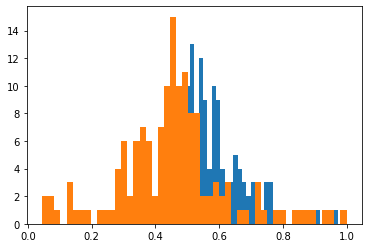

In [838]:
plt.hist(avg_intensity/np.nanmax(avg_intensity), 50)
plt.hist(avg_intensity2/np.nanmax(avg_intensity2), 50)

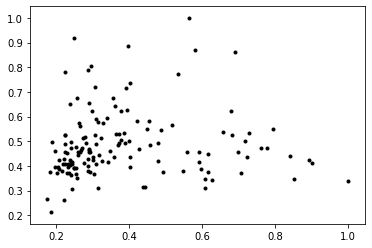

In [32]:
plt.scatter(avg_intensity_npy/np.nanmax(avg_intensity_npy), 
            avg_intensity_egln3/np.nanmax(avg_intensity_egln3), color = 'k', marker = '.')
plt.savefig('C:\\Users\\singha\\Documents\\Janelia admin stuff\\2019_hopkins_poster\\ndnf_dist.eps')

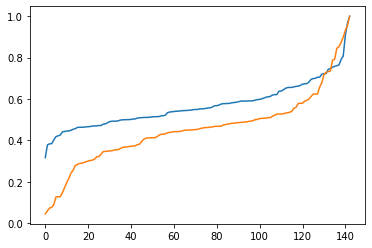

In [837]:
plt.plot(np.sort(avg_intensity)/np.nanmax(avg_intensity))
plt.plot(np.sort(avg_intensity2)/np.nanmax(avg_intensity2))

In [799]:
layer.data[plane, mask].shape

(226,)

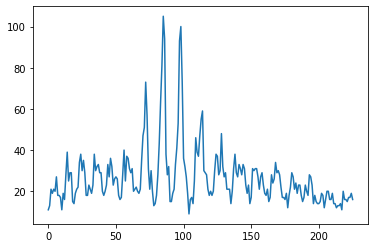

In [801]:
plt.plot(layer.data[plane, mask])

(0, 100)

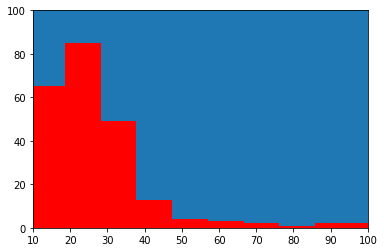

In [807]:
fig = plt.figure()
plt.hist(np.reshape(layer.data[plane, :, :], [-1]), 100)
plt.hist(layer.data[plane, mask], color = 'r')
plt.xlim(10, 100)
plt.ylim(0, 100)

In [806]:
layer.data[plane, mask]

array([ 11.,  13.,  21.,  19.,  21.,  20.,  27.,  18.,  18.,  17.,  11.,
        19.,  16.,  28.,  39.,  25.,  29.,  29.,  15.,  14.,  19.,  21.,
        22.,  34.,  38.,  30.,  35.,  29.,  18.,  18.,  23.,  21.,  19.,
        23.,  38.,  30.,  32.,  33.,  29.,  29.,  20.,  18.,  20.,  23.,
        33.,  27.,  36.,  32.,  23.,  26.,  27.,  26.,  18.,  16.,  17.,
        28.,  40.,  25.,  37.,  36.,  31.,  29.,  31.,  20.,  21.,  22.,
        20.,  19.,  21.,  35.,  47.,  51.,  73.,  57.,  31.,  21.,  30.,
        20.,  13.,  14.,  18.,  28.,  43.,  63.,  81., 105.,  94.,  38.,
        28.,  32.,  15.,  15.,  19.,  21.,  33.,  41.,  53.,  93., 100.,
        73.,  36.,  32.,  27.,  19.,   9.,  16.,  17.,  14.,  25.,  46.,
        39.,  37.,  47.,  55.,  59.,  30.,  29.,  28.,  21.,  18.,  20.,
        18.,  20.,  30.,  38.,  37.,  28.,  30.,  48.,  32.,  27.,  29.,
        21.,  21.,  21.,  14.,  20.,  31.,  38.,  29.,  27.,  33.,  31.,
        28.,  33.,  31.,  23.,  19.,  23.,  14.,  1